In [27]:
import json
import numpy as np
import pandas as pd
from clean import CleanData
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
data = json.load(open('./data/trending.json', encoding="utf8"))
data = data['collector']
toParse = pd.json_normalize(data)
df = CleanData(toParse)
df.process_the_data()
df.summary_of_data()

Missing Data:
None

Data Time Period:
Start Date: 2020-09-22 14:22:38
  End Date: 2020-12-21 03:18:36
 Timedelta: 89 days 12:55:58


In [188]:
df_clean = df.dfm
# df_clean.sort_values(by=['likeCount'],ascending=False).head(1).T

In [186]:
segmentDf = df_clean[['authorMeta.name','authorMeta.verified','shareRate','likeRate','commentRate','playCount','shareCount','likeCount','commentCount']]
segmentDf = segmentDf.groupby(['authorMeta.name','authorMeta.verified'],as_index=False).agg(np.mean)
segmentDf = segmentDf.sort_values(by='likeRate',ascending=False)#.head(3).T
segmentDf.head(3).T

,57,399,595
authorMeta.name,anwarali0125,l3fty_fr3ak,reus.fx
authorMeta.verified,False,False,False
shareRate,0.003181,0.020488,0.017623
likeRate,0.485684,0.446655,0.375128
commentRate,0.008484,0.011573,0.007987
playCount,943.0,55300.0,232950.0
shareCount,3.0,1133.0,4390.0
likeCount,458.0,24700.0,87850.0
commentCount,8.0,640.0,1832.0


In [31]:
segmentDf['authorMeta.verified'].unique()

array([False,  True])

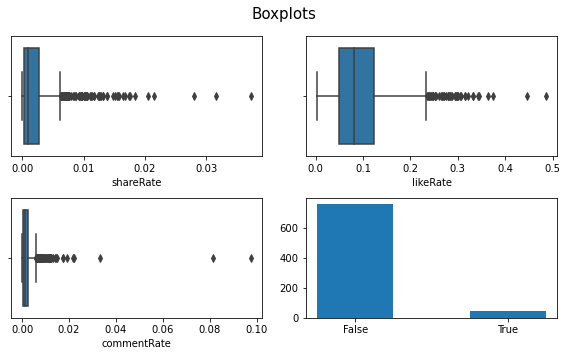

In [35]:
fig = plt.figure(figsize=(8, 5), tight_layout=True)
plt.suptitle('Boxplots', fontsize=15)
fig.add_subplot(221)
sns.boxplot(x='shareRate', data=segmentDf)
fig.add_subplot(222)
sns.boxplot(x='likeRate', data=segmentDf)
fig.add_subplot(223)
sns.boxplot(x='commentRate', data=segmentDf)
ax = fig.add_subplot(224)

categories = segmentDf['authorMeta.verified'].unique()
counts = segmentDf['authorMeta.verified'].value_counts()
pos = [0,1]
ax.bar(pos,counts,width=0.5)

ax.set_xticks(pos)
ax.set_xticklabels(categories)

plt.show()

In [36]:
df_clean[['createTime']].groupby(df_clean["createTime"].dt.month).count().transpose()

createTime,9,10,11,12
createTime,80,325,311,284


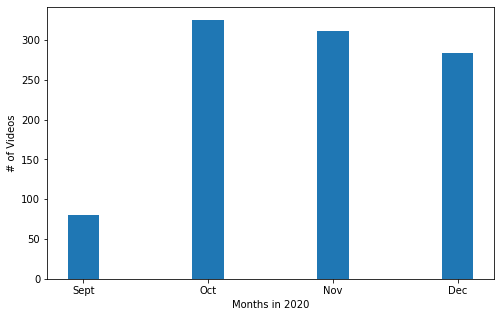

In [131]:
pivot_df = df_clean[['createTime']].groupby(df_clean["createTime"].dt.month).count()#.sort_values(by='videoMeta.duration',axis=1)#.plot(kind="bar", legend=False)
pivot_df = pivot_df.rename(columns={"createTime": "count"})
pivot_df = pivot_df.reset_index()

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
x = pivot_df['createTime']
y = pivot_df['count']

ax.bar(x,y,width=0.25)
ax.set_xticks(np.arange(min(x), max(x)+1, 1))
ax.set_xticklabels(['Sept','Oct','Nov','Dec'])
ax.set_xlabel('Months in 2020')
ax.set_ylabel('# of Videos')
plt.show()

In [192]:
count_df = df_clean[['videoMeta.duration']].groupby(df_clean["videoMeta.duration"]).count()#.sort_values(by='videoMeta.duration',axis=1)#.plot(kind="bar", legend=False)
count_df = count_df.rename(columns={"videoMeta.duration": "count"})
count_df = count_df.reset_index()

avg_df = df_clean[['videoMeta.duration','likeCount','shareCount','playCount','commentCount']]
avg_df = avg_df.groupby(['videoMeta.duration'],as_index=False).agg([np.mean]).reset_index()
avg_df.columns = avg_df.columns.droplevel(-1)
# avg_df.sort_values(by='likeCount',ascending=False).head(3).T
avg_df.head()

,videoMeta.duration,likeCount,shareCount,playCount,commentCount
0,4,2232.000000,19.000000,4.790000e+04,27.000000
1,5,27612.000000,1105.615385,3.385538e+05,389.153846
2,6,16755.857143,493.476190,2.459732e+05,158.238095
3,7,45123.641026,1008.641026,7.938128e+05,266.871795
4,8,124246.000000,3537.272727,1.078814e+06,1183.606061


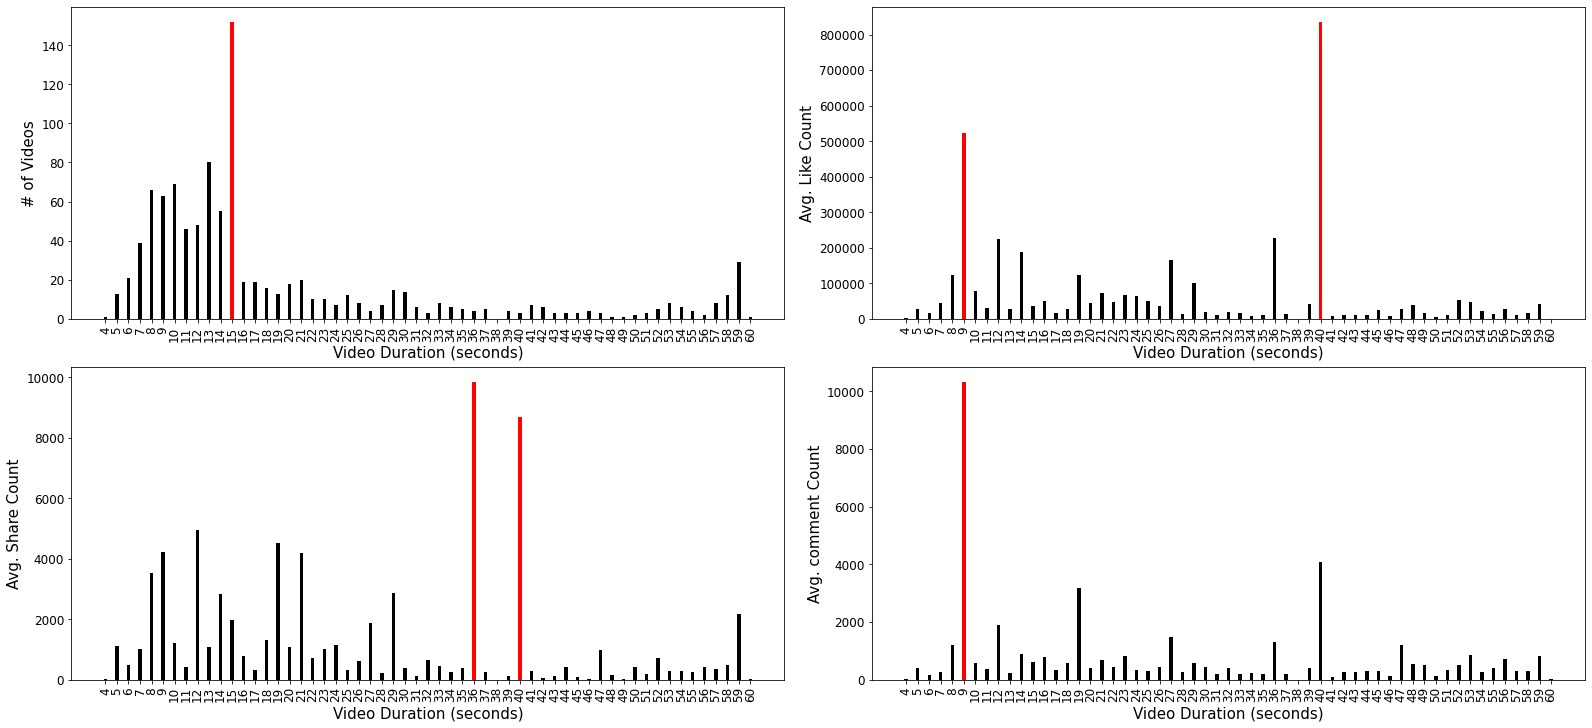

In [201]:
fig = plt.figure(figsize=(22,10),constrained_layout=True)
bar_width = 0.3

ax1 = fig.add_subplot(221)
x = count_df['videoMeta.duration']
y = count_df['count']

ax1.bar(x,y, color='k', width=bar_width)
ax1.set_xticks(np.arange(min(x), max(x)+1, 1))
ax1.set_xticklabels(ax1.get_xticks(),rotation=90)
ax1.set_xlabel('Video Duration (seconds)', fontdict={'fontsize': 15})
ax1.set_ylabel('# of Videos', fontdict={'fontsize': 15})
ax1.tick_params(axis='both', which='major', labelsize=12)

ax1.bar([15], count_df[count_df['videoMeta.duration'] == 15]['count'].iloc[0], color='r', width=bar_width)

ax2 = fig.add_subplot(222)
x = avg_df['videoMeta.duration']
y = avg_df['likeCount']

ax2.bar(x,y,color='k', width=bar_width)
ax2.set_xticks(np.arange(min(x), max(x)+1, 1))
ax2.set_xticklabels(ax2.get_xticks(),rotation=90)
ax2.set_xlabel('Video Duration (seconds)', fontdict={'fontsize': 15})
ax2.set_ylabel('Avg. Like Count', fontdict={'fontsize': 15})
ax2.tick_params(axis='both', which='major', labelsize=12)

target = [9,40]
ax2.bar(target, avg_df[avg_df['videoMeta.duration'].isin(target)]['likeCount'], color='r', width=bar_width)

ax3 = fig.add_subplot(223)
x = avg_df['videoMeta.duration']
y = avg_df['shareCount']

ax3.bar(x,y,color='k', width=bar_width)
ax3.set_xticks(np.arange(min(x), max(x)+1, 1))
ax3.set_xticklabels(ax3.get_xticks(),rotation=90)
ax3.set_xlabel('Video Duration (seconds)', fontdict={'fontsize': 15})
ax3.set_ylabel('Avg. Share Count', fontdict={'fontsize': 15})
ax3.tick_params(axis='both', which='major', labelsize=12)

target = [36,40]
ax3.bar(target, avg_df[avg_df['videoMeta.duration'].isin(target)]['shareCount'], color='r', width=bar_width)

ax4 = fig.add_subplot(224)
x = avg_df['videoMeta.duration']
y = avg_df['commentCount']

ax4.bar(x,y,color='k', width=bar_width)
ax4.set_xticks(np.arange(min(x), max(x)+1, 1))
ax4.set_xticklabels(ax4.get_xticks(),rotation=90)
ax4.set_xlabel('Video Duration (seconds)', fontdict={'fontsize': 15})
ax4.set_ylabel('Avg. comment Count', fontdict={'fontsize': 15})
ax4.tick_params(axis='both', which='major', labelsize=12)

target = [9]
ax4.bar(target, avg_df[avg_df['videoMeta.duration'].isin(target)]['commentCount'], color='r', width=bar_width)

plt.show()